In [3]:
import os, sys
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5_qdess, num_params
from include.decoder_conv import init_convdecoder
from include.fit import fit
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals

from torch.autograd import Variable
import copy
import numpy as np
import time

dtype = torch.cuda.FloatTensor

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(0)

In [4]:
def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

In [19]:
id_list = ['005', '006', '030', '034']#, '048', '052', '065', 
#            '080', '096', '099', '120', '144', '156', '158',
#            '176', '178', '188', '196', '198', '199', '218', '219', 
#            '221', '223', '224', '227', '235', '237', '240', '241',
#            '244', '248']

In [25]:
e_num_list = [1,2]
accel_list = [4]
lam_tv = 1e-9

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_VARS = 4
NUM_METRICS = 4

for accel in accel_list:

    path_bl = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/'.format(accel) # baseline method
    path_new = path_bl + 'loss_tv_tune/' # new method against which we're comparing

    metrics_bl = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_new = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, 512, 160))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):
            
            path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

            im_gt = np.load('{}MTR_{}_e{}_gt.npy'.format(path_bl, id_, e_num))  
            im_gt_new = np.load('{}MTR_{}_e{}_gt.npy'.format(path_new, id_, e_num))
            if abs(im_gt - im_gt_new).max() != 0:
                raise ValueError('ground-truths do not match for MTR_{}'.format(id_))
                continue

            im_dc = np.load('{}MTR_{}_e{}_dc.npy'.format(path_bl, id_, e_num))  
            im_dc_new = np.load('{}MTR_{}_e{}_dc_tv{}.npy'.format(path_new, id_, e_num, lam_tv))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc, im_dc_new = im_gt/im_gt.max(), im_dc/im_dc.max(), im_dc_new/im_dc_new.max()

            metrics_bl[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_new[idx_e][idx] = calc_metrics(im_gt, im_dc_new)

            C = 4
            im_diff = C * (im_dc - im_dc_new)
            
            im_list[idx][idx_e] = np.array([im_gt, im_dc, im_dc_new, im_diff])

    perc_diff_list = (metrics_new - metrics_bl) / metrics_bl

    vals_bl = np.mean(metrics_bl, axis=1)
    vals_new = np.mean(metrics_new, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
    print('accel {}x \n'.format(accel))
    print('recon bl method')
    print(vals_bl, '\n')
    print('recon new method')
    print(vals_new, '\n')
    print('perc diff')
    print(perc_diff)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

accel 4x 

recon bl method
[[ 0.90516687  0.96979244  0.86030198 33.14598019]
 [ 0.70206742  0.92980848  0.76556211 32.79345536]] 

recon new method
[[ 0.90901974  0.96967298  0.86156275 33.14419792]
 [ 0.7104579   0.93161583  0.77240683 32.87318643]] 

perc diff
[[ 4.24088874e-03 -1.21990864e-04  1.45950186e-03 -2.93566615e-05]
 [ 1.17954255e-02  1.89729949e-03  8.40320638e-03  2.23769025e-03]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



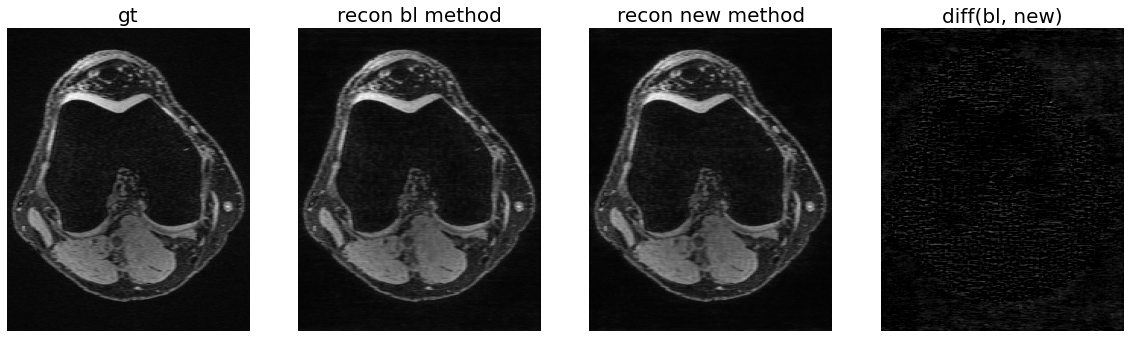

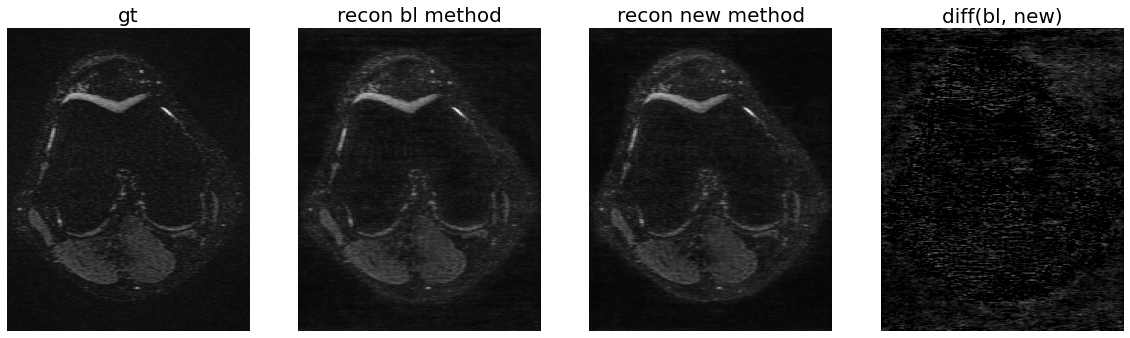

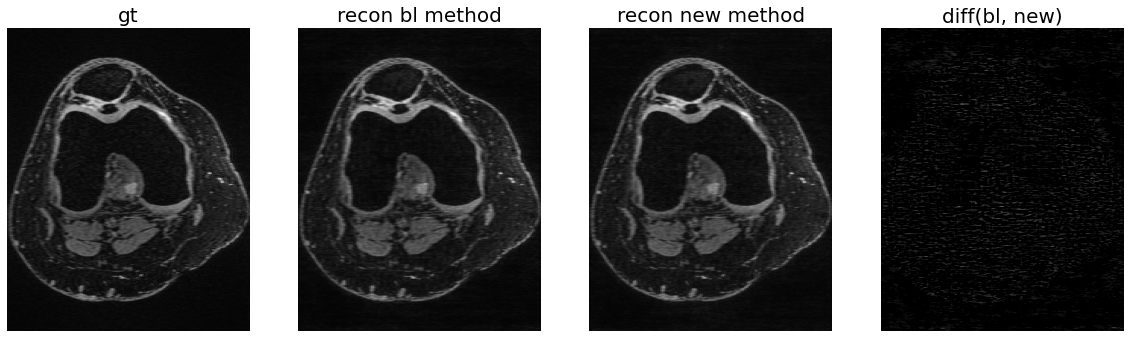

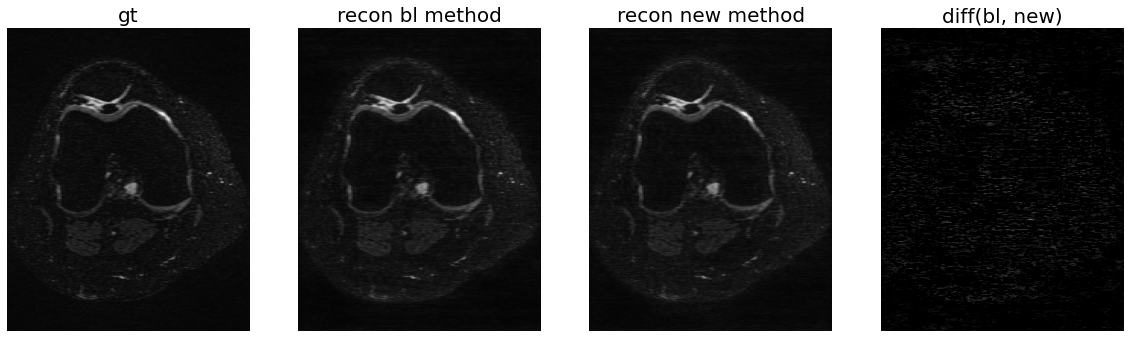

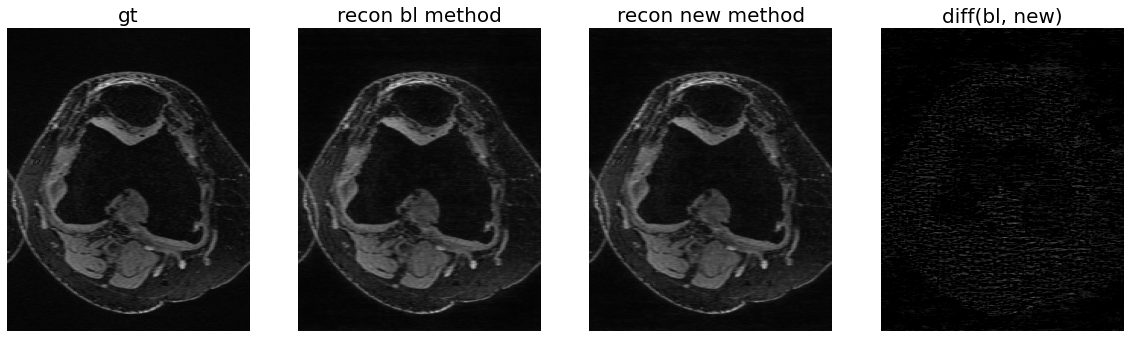

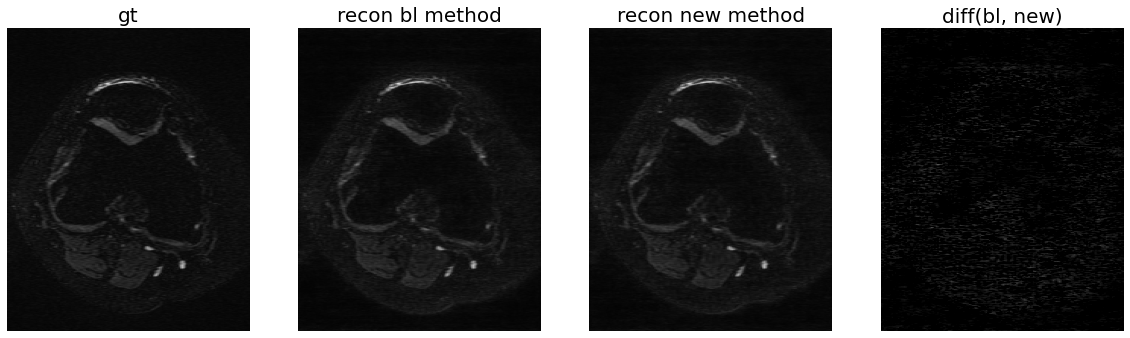

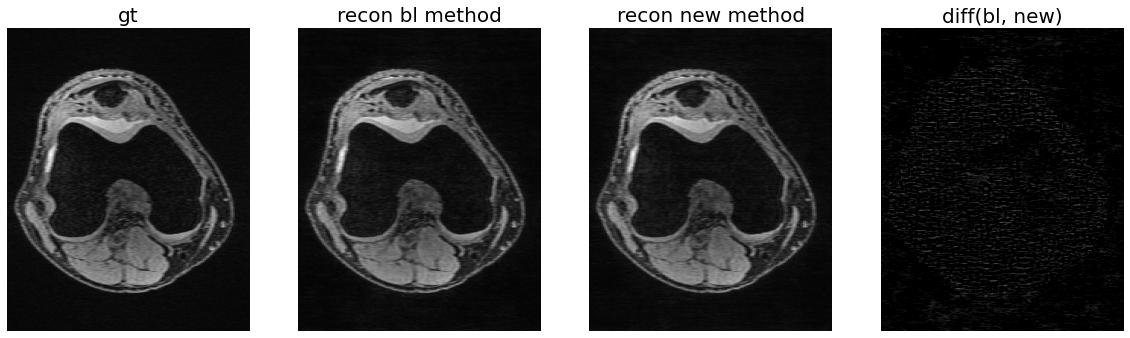

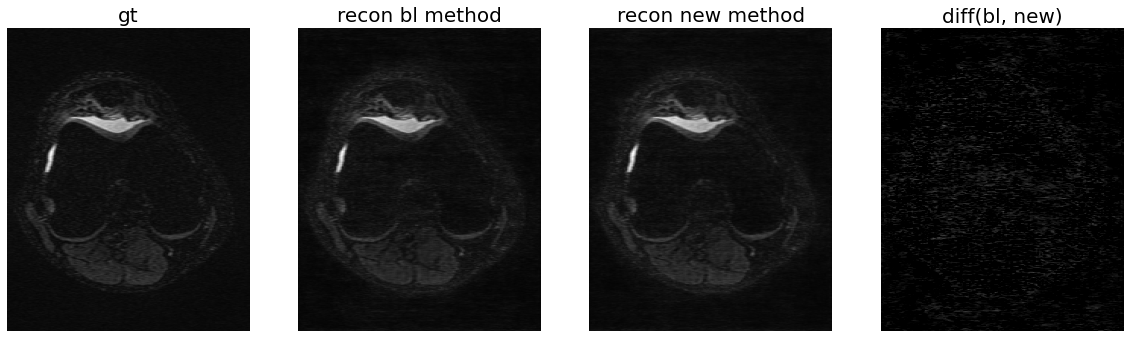

In [22]:
title_list = ['gt', 'recon bl method', 'recon new method', 'diff(bl, new)']

for idx_s, _ in enumerate(im_list):
    for e in im_list[idx_s]:
        plot_list(e, title_list)

# PROTOTYPE new loss f'ns below

In [73]:
ACCEL_LIST = [4] # 4, 6, 8]
NUM_ITER = 201

def run_expmt(file_id_list):

    for file_id in file_id_list:

#         t0 = time.time()
#         ksp = load_h5_qdess(file_id)
#         t1 = time.time()
        
#         # load, concat both echo slices
#         idx_kx = ksp.shape[0] // 2 # want central slice in kx (axial) b/c we undersample in (ky,kz)
#         ksp_echo1 = ksp[:,:,:,0,:].permute(3,0,1,2)[:, idx_kx, :, :]
#         ksp_echo2 = ksp[:,:,:,1,:].permute(3,0,1,2)[:, idx_kx, :, :]
#         ksp_orig = torch.cat((ksp_echo1, ksp_echo2), 0)
        
#         np.save('delete_me_ksp_orig_mtr_005.npy', np.array(ksp_orig))

        ksp_orig = torch.from_numpy(np.load('delete_me_ksp_orig_mtr_005.npy'))

        for ACCEL in ACCEL_LIST:

            path_out = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/new_layers/'.format(ACCEL)
            if os.path.exists('{}{}_e1-joint-recon_dc.npy'.format(path_out, file_id)):
                continue

            # original masks created w central region 32x32 forced to 1's
            mask = torch.from_numpy(np.load('/home/vanveen/ConvDecoder/ipynb/masks/mask_poisson_disc_{}x.npy'.format(ACCEL)))

            # initialize network
            net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

            # apply mask after rescaling k-space. want complex tensors dim (nc, ky, kz)
            ksp_masked = ksp_orig_ * mask
            img_masked = ifft_2d(ksp_masked)

            # fit network, get net output

            net, mse_wrt_ksp, mse_wrt_img = fit(
                ksp_masked=ksp_masked, img_masked=img_masked,
                net=net, net_input=net_input, mask2d=mask, num_iter=NUM_ITER)
            img_out = net(net_input.type(dtype)) # real tensor dim (2*nc, kx, ky)
            img_out = reshape_adj_channels_to_complex_vals(img_out[0]) # complex tensor dim (nc, kx, ky)

            # perform dc step
            ksp_est = fft_2d(img_out)
            ksp_dc = torch.where(mask, ksp_masked, ksp_est)
        
#         t2 = time.time()
#         print(t1-t0)
#         print(t2-t1)

In [111]:
def fit(ksp_masked, img_masked, net, net_input, mask2d,
        mask1d=None, ksp_orig=None, DC_STEP=False, alpha=0.5,
        num_iter=5000, lr=0.01, img_ls=None, dtype=torch.cuda.FloatTensor,
        c_wmse=None, LOSS_IN_KSP=False):
    
    # initialize variables
    if img_ls is not None or net_input is None:
        raise NotImplementedError('incorporate original code here')
    if alpha < 0 or alpha >= 1:
        raise ValueError('alpha must be non-negative and strictly less than 1')
    net_input = net_input.type(dtype)
    best_net = copy.deepcopy(net)
    best_mse = 10000.0
    mse_wrt_ksp, mse_wrt_img = np.zeros(num_iter), np.zeros(num_iter)

    p = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr,weight_decay=0)
    mse = torch.nn.MSELoss()

    # convert complex [nc,x,y] --> real [2*nc,x,y] to match w net output
    ksp_masked = reshape_complex_vals_to_adj_channels(ksp_masked).cuda()
    img_masked = reshape_complex_vals_to_adj_channels(img_masked)[None,:].cuda()
    mask2d = mask2d.cuda()

    for i in range(num_iter):
        def closure(): # execute this for each iteration (gradient step)

            optimizer.zero_grad()

            out = net(net_input) # out is in img space            
            if LOSS_IN_KSP:
                out_ksp_masked = forwardm(out, mask2d).cuda() # convert img to ksp, apply mask
                loss_ksp = mse(out_ksp_masked, ksp_masked)
                loss_ksp.backward(retain_graph=False)
            else:
                out_img_masked = forwardm_img(out, mask2d) # img-->ksp, apply mask, convert to img
                loss_img = mse(out_img_masked, img_masked)
                loss_tv = (torch.sum(torch.abs(out_img_masked[:,:,:,:-1] - out_img_masked[:,:,:,1:])) \
                         + torch.sum(torch.abs(out_img_masked[:,:,:-1,:] - out_img_masked[:,:,1:,:])))
                loss_total = loss_img + 1e-11 * loss_tv
#                 loss_img.backward(retain_graph=False)
                loss_total.backward(retain_graph=False)
                
                if i == 0:
                    print(out_img_masked.shape)
                
                if i % 100 == 0 and i != 0:
                    print(float(loss_img), float(loss_tv))
                    im_plot = root_sum_squares(reshape_adj_channels_to_complex_vals(out_img_masked[0]))
                    plt.imshow(im_plot.detach().numpy(), cmap='gray', aspect=1./2.56)
                    plt.show()

#             mse_wrt_ksp[i] = loss_ksp.data.cpu().numpy() # store loss over each iteration
            if LOSS_IN_KSP:
                return loss_ksp
            else:
                return loss_total #loss_img

        loss = optimizer.step(closure)

        # at each iteration, check if loss improves by 1%. if so, a new best net
        loss_val = loss.data
        if best_mse > 1.005*loss_val:
            best_mse = loss_val
            best_net = copy.deepcopy(net)

    return best_net, mse_wrt_ksp, mse_wrt_img

def forwardm_img(img, mask):
    ''' convert img --> ksp (must be complex for fft), apply mask
        convert back to img. input dim [2*nc,x,y], output dim [1,2*nc,x,y] '''

    img = reshape_adj_channels_to_complex_vals(img[0])
    ksp = fft_2d(img).cuda()
    ksp_masked_ = ksp * mask
    img_masked_ = ifft_2d(ksp_masked_)
    
    return reshape_complex_vals_to_adj_channels(img_masked_)[None, :]

def forwardm(img, mask):
    ''' convert img --> ksp (must be complex for fft), apply mask
        input, output should have dim [2*nc,x,y] '''

    img = reshape_adj_channels_to_complex_vals(img[0])
    ksp = fft_2d(img).cuda()
    ksp_masked_ = ksp * mask

    return reshape_complex_vals_to_adj_channels(ksp_masked_)

# TODO

- get baseline recon in im-space using l2. should be the same as k-space. verify this.
- next, add tv reg

In [112]:
# 1e-6 too much
# 1e-7: 0.0411672480404377 99276.265625
# 1e-8: 0.03801078349351883 126327.421875
# 1e-9: 0.03724750503897667 132994.65625
# 1e-10: 0.038964513689279556 125631.6875
# 1e-11: 0.04309595376253128 126975.3671875
# 0: 0.04017949849367142 128942.4453125

torch.Size([1, 32, 512, 160])
0.06075498089194298 91424.15625


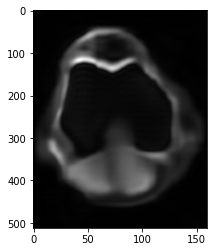

0.04309595376253128 126975.3671875


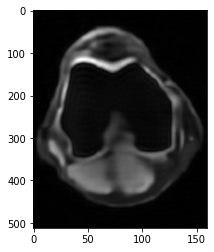

In [113]:
run_expmt(file_id_list)

# DELETE ME

comparing loss_ksp v loss_img. result: exactly the same

In [ ]:
e_num_list = [1,2]
accel_list = [4]

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_VARS = 4
NUM_METRICS = 4

for accel in accel_list:

    path_bl = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/'.format(accel) # baseline method
    path_new = path_bl + 'loss_img_l2/' # new method against which we're comparing

    metrics_bl = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_new = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, 512, 160))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):
            
            path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

            im_gt = np.load('{}/MTR_{}_e{}_gt.npy'.format(path_bl, id_, e_num))  
            im_gt_new = np.load('{}/MTR_{}_e{}_gt.npy'.format(path_new, id_, e_num))
            if abs(im_gt - im_gt_new).max() != 0:
                raise ValueError('ground-truths do not match for MTR_{}'.format(id_))
                continue

            im_dc = np.load('{}/MTR_{}_e{}_dc.npy'.format(path_bl, id_, e_num))  
            im_dc_new = np.load('{}/MTR_{}_e{}_dc.npy'.format(path_new, id_, e_num))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc, im_dc_new = im_gt/im_gt.max(), im_dc/im_dc.max(), im_dc_new/im_dc_new.max()

            metrics_bl[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_new[idx_e][idx] = calc_metrics(im_gt, im_dc_new)

            C = 4
            im_diff = C * (im_dc - im_dc_new)
            
            im_list[idx][idx_e] = np.array([im_gt, im_dc, im_dc_new, im_diff])

    perc_diff_list = (metrics_new - metrics_bl) / metrics_bl

    vals_bl = np.mean(metrics_bl, axis=1)
    vals_new = np.mean(metrics_new, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
    print('accel {}x \n'.format(accel))
    print('recon bl method')
    print(vals_bl, '\n')
    print('recon new method')
    print(vals_new, '\n')
    print('perc diff')
    print(perc_diff)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')